In [16]:
import os
import numpy as np
import string
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam

# Config
DATA_DIR = "Flicker8k_Dataset"
CAPTIONS_FILE = f"{DATA_DIR}/captions.txt"
IMAGE_DIR = f"{DATA_DIR}/Images"
MAX_VOCAB_SIZE = 5000
MAX_LENGTH = 30
EMBED_DIM = 256
BATCH_SIZE = 32
EPOCHS = 20
BEAM_WIDTH = 3
USE_BEAM_SEARCH = False

# Memory growth on GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Step 1: Load and clean captions ###
def load_captions(filepath):
    captions = {}
    with open(filepath, 'r') as f:
        for line in f:
            tokens = line.strip().split(',', 1)
            if len(tokens) < 2:
                continue
            img_id = tokens[0].split('.')[0]
            caption = tokens[1].lower().translate(str.maketrans('', '', string.punctuation))
            captions.setdefault(img_id, []).append("startseq " + caption + " endseq")
    return captions

captions_dict = load_captions(CAPTIONS_FILE)

### Step 2: Extract MobileNetV2 features ###
def preprocess_image(path):
    img = Image.open(path).resize((224, 224)).convert('RGB')
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(directory):
    features = {}
    for img_name in tqdm(os.listdir(directory)):
        if not img_name.lower().endswith(".jpg"):
            continue
        img_id = img_name.split('.')[0]
        path = os.path.join(directory, img_name)
        try:
            img = preprocess_image(path)
            feature = mobilenet.predict(img, verbose=0)
            features[img_id] = feature[0]
        except:
            continue
    return features

features_dict = extract_features(IMAGE_DIR)
captions_dict = {k: v for k, v in captions_dict.items() if k in features_dict}

### Step 3: Tokenizer and Sequence Prep ###
all_captions = [caption for caps in captions_dict.values() for caption in caps]
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_len = min(MAX_LENGTH, max(len(c.split()) for c in all_captions))

### Step 4: Data Splitting ###
keys = list(captions_dict.keys())
np.random.shuffle(keys)
train_split = int(0.8 * len(keys))
val_split = int(0.9 * len(keys))

train_keys = keys[:train_split]
val_keys = keys[train_split:val_split]
test_keys = keys[val_split:]

### Step 5: Data Generator ###
def data_generator(keys, captions_dict, features_dict, tokenizer, max_len, vocab_size, batch_size=32):
    while True:
        X1, X2, y = [], [], []
        for key in keys:
            captions = captions_dict.get(key, [])
            feature = features_dict.get(key)
            if feature is None:
                continue
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq = pad_sequences([seq[:i]], maxlen=max_len)[0]
                    out_seq = seq[i]  # integer label
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    if len(X1) == batch_size:
                        yield [np.array(X1), np.array(X2)], np.array(y)
                        X1, X2, y = [], [], []

/tmp/ipykernel_2788617/3423698224.py:59: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
100%|██████████| 7564/7564 [10:58<00:00, 11.49it/s]


In [6]:
print("GENERATING")
train_generator = data_generator(train_keys, captions_dict, features_dict, tokenizer, max_len, vocab_size, BATCH_SIZE)
print("TRAIN COMPLETE")
val_generator = data_generator(val_keys, captions_dict, features_dict, tokenizer, max_len, vocab_size, BATCH_SIZE)
print("VAL COMPLETE")
print("GENERATION COMPLETE")

train_steps = sum(len(captions_dict[k]) for k in train_keys)
val_steps = sum(len(captions_dict[k]) for k in val_keys)


GENERATING
TRAIN COMPLETE
VAL COMPLETE
GENERATION COMPLETE


In [14]:
### Step 6: Build Model ###
def build_model(vocab_size, max_len):
    inputs1 = Input(shape=(1280,))
    fe1 = Dense(EMBED_DIM, activation='relu')(inputs1)

    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, EMBED_DIM, mask_zero=False)(inputs2)
    se2 = LSTM(256)(se1)

    decoder1 = Concatenate()([fe1, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())
    return model

model = build_model(vocab_size, max_len)
model.summary()

def tuple_wrapper(gen):
    for x, y in gen:
        yield tuple(x), y

EPOCHS = 100

### Step 7: Train Model ###
model.fit(
    tuple_wrapper(train_generator),
    steps_per_epoch=train_steps // BATCH_SIZE,
    validation_data=tuple_wrapper(val_generator),
    validation_steps=val_steps // BATCH_SIZE,
    epochs=EPOCHS
)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 30, 256)   │  2,193,408 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    327,936 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8568)      │  2,201,976 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,379,960 (20.52 MB)

 Trainable params: 5,379,960 (20.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 5.4959 - val_loss: 4.5829
Epoch 2/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 4.3650 - val_loss: 4.2038
Epoch 3/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 4.0767 - val_loss: 3.9591
Epoch 4/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.9583 - val_loss: 3.8566
Epoch 5/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.8848 - val_loss: 3.8038
Epoch 6/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.8712 - val_loss: 3.7718
Epoch 7/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.7769 - val_loss: 3.7514
Epoch 8/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.7792 - val_loss: 3.6869
Epoch 9/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 3.6467 - val_loss: 3.6979
Epoch 10/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.6611 - val_loss: 3.5294
Epoch 11/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.5925 - val_loss: 3.6289
Epoch 12/100
945/94

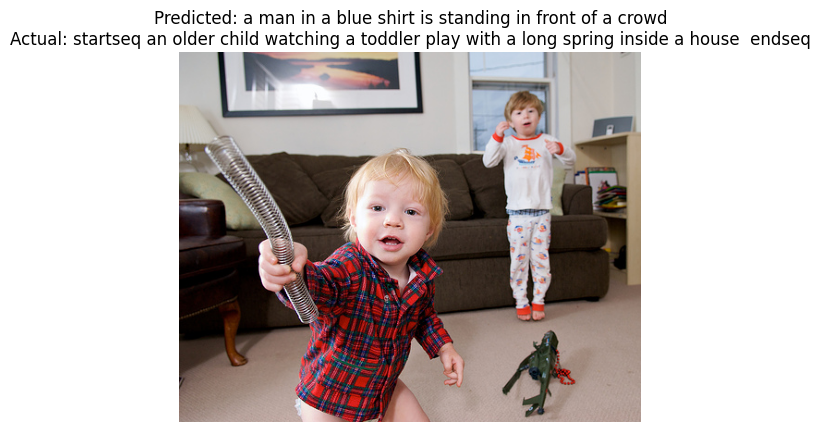

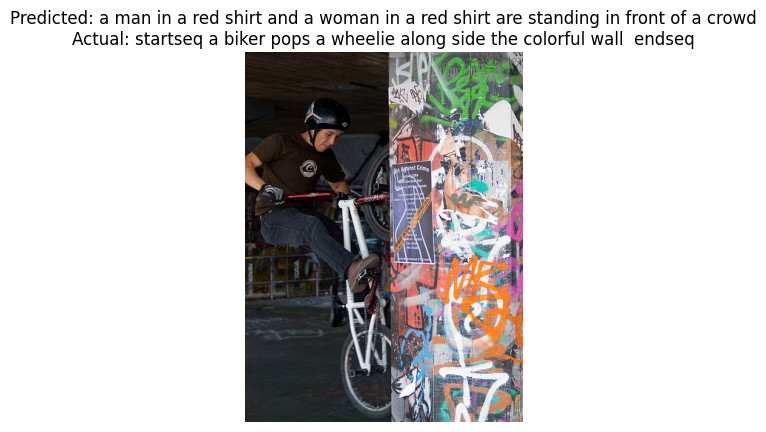

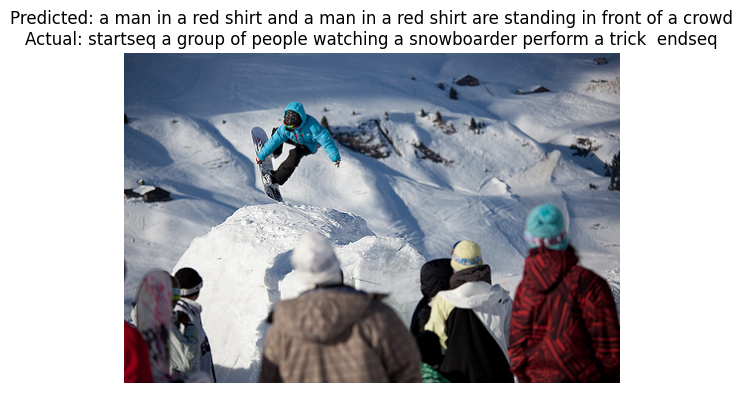

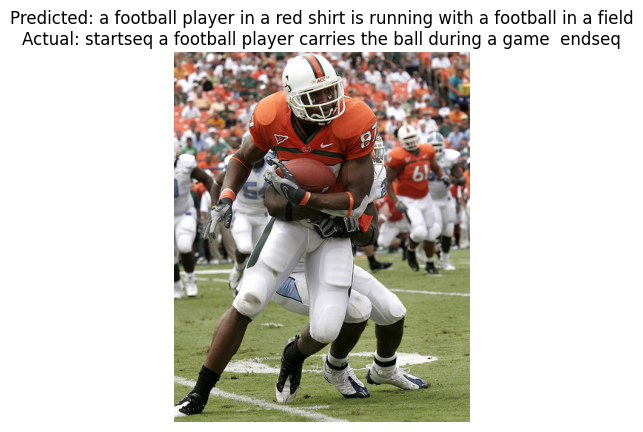

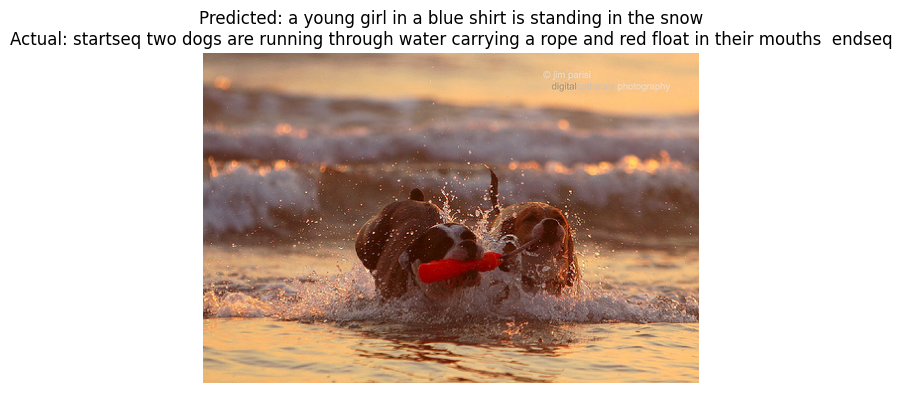

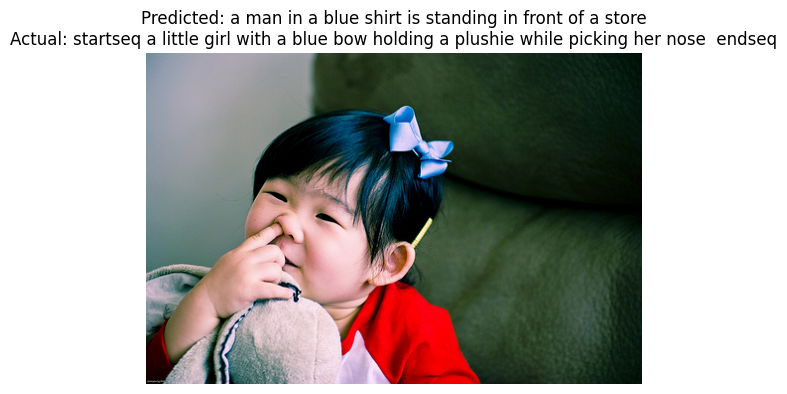

BLEU-1: 0.3590
BLEU-4: 0.0669


In [15]:
import matplotlib.pyplot as plt

# Function to generate a caption using greedy search
def generate_caption(model, tokenizer, photo, max_len):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([np.array([photo]), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, '')
        if word == 'endseq' or word == '':
            break
        in_text += ' ' + word
    return in_text.replace('startseq ', '').replace(' endseq', '')

# Show sample predictions and compute BLEU score
def evaluate_model(model, captions_dict, features_dict, tokenizer, test_keys, max_len, num_samples):
    actual, predicted = [], []

    for i, key in enumerate(test_keys[:num_samples]):
        photo = features_dict[key]
        y_pred = generate_caption(model, tokenizer, photo, max_len)
        y_true = [c.split() for c in captions_dict[key]]

        actual.append(y_true)
        predicted.append(y_pred.split())

        # Display image and captions
        img_path = os.path.join(IMAGE_DIR, key + '.jpg')
        image = Image.open(img_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {y_pred}\nActual: {captions_dict[key][0]}")
        plt.show()

    # Compute BLEU score
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")

# Run evaluation after training
evaluate_model(model, captions_dict, features_dict, tokenizer, test_keys, max_len, num_samples=10)
